In [ ]:
import pandas as pd
import os
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define paths (Adjust 'Loan_Project' if you named your folder something else)
base_path = '/content/drive/MyDrive/Loan_Project'
raw_data_path = os.path.join(base_path, 'raw_data')

# 3. Verify files exist
print("Checking for files...")
if os.path.exists(raw_data_path):
    files = os.listdir(raw_data_path)
    print(f"Files found in {raw_data_path}:")
    for f in files:
        print(f" - {f}")
else:
    print(f"ERROR: Path {raw_data_path} not found. Check your folder name in Drive.")

# 4. Test Load (Load just 5 rows to check connection)
# We use error_bad_lines=False or on_bad_lines='skip' because these files sometimes have parsing errors
try:
    print("\nAttempting to load first 5 rows of Accepted Loans...")
    accepted_path = os.path.join(raw_data_path, 'accepted_2007_to_2018Q4.csv')
    df_test = pd.read_csv(accepted_path, nrows=5)
    print("Success! Columns detected:", list(df_test.columns[:5]), "...")
except Exception as e:
    print("Error loading data:", e)

Mounted at /content/drive
Checking for files...
Files found in /content/drive/MyDrive/Loan_Project/raw_data:
 - accepted_2007_to_2018Q4.csv
 - rejected_2007_to_2018Q4.csv

Attempting to load first 5 rows of Accepted Loans...
Success! Columns detected: ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv'] ...


Loading Risk Data...


/tmp/ipython-input-739674964.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='grade', y='target_default', data=default_rates, order=grade_order, palette='Reds')


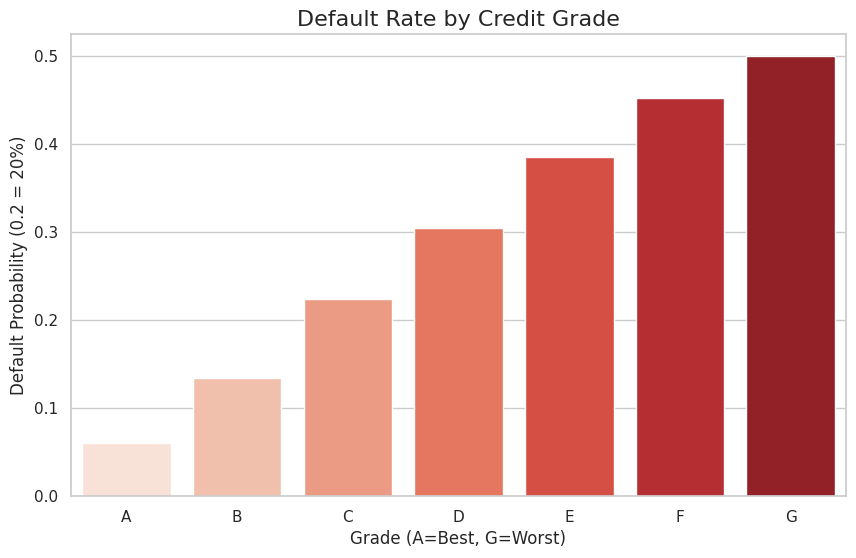

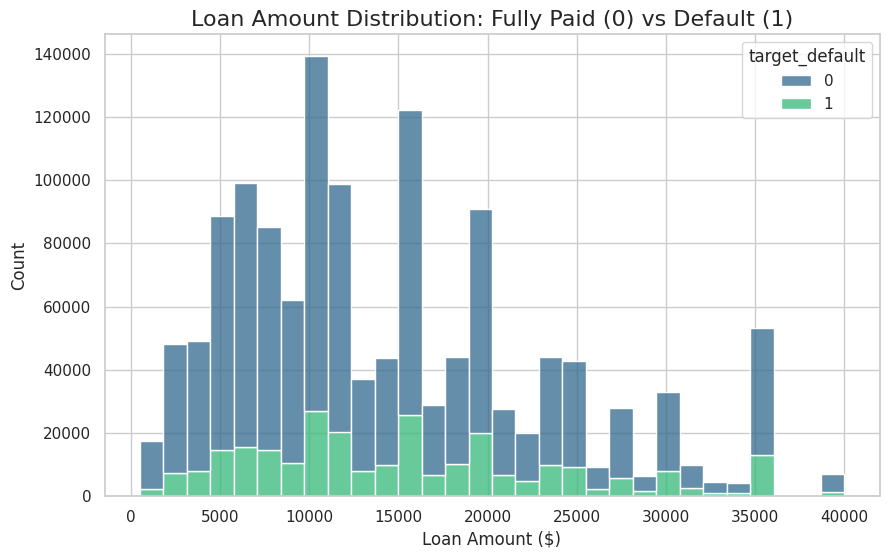

/tmp/ipython-input-739674964.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='grade', y='int_rate', data=df, order=grade_order, palette='coolwarm')


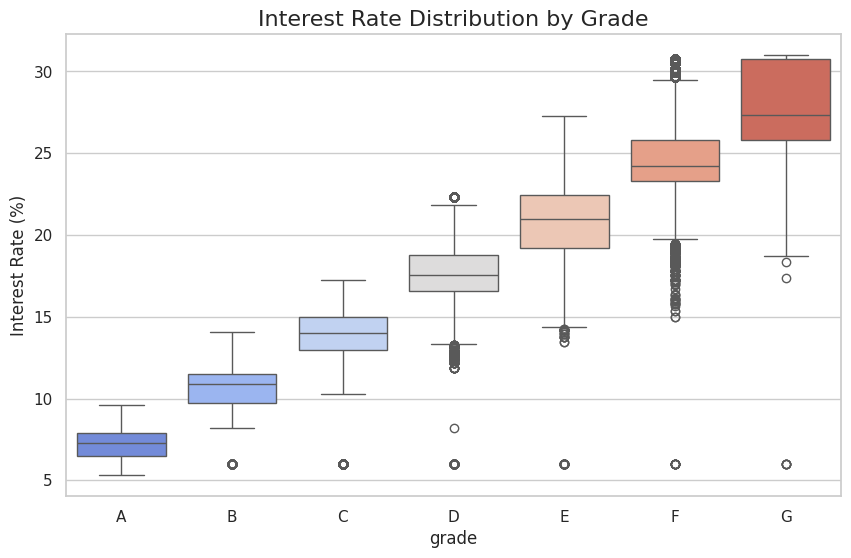

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 1. Load the Risk Data (It's smaller and has the financial outcome info)
base_path = '/content/drive/MyDrive/Loan_Project' # Adjust if needed
risk_path = os.path.join(base_path, 'risk_data_clean.csv')

print("Loading Risk Data...")
df = pd.read_csv(risk_path)

# Set plotting style
sns.set_theme(style="whitegrid")

# --- CHART 1: DEFAULT RATE BY GRADE ---
# This is the "Holy Grail" chart in credit risk.
# It proves that lower grades (F/G) are riskier than high grades (A/B).
plt.figure(figsize=(10, 6))
# Calculate default rate per grade
grade_order = sorted(df['grade'].unique())
default_rates = df.groupby('grade')['target_default'].mean().reset_index()

sns.barplot(x='grade', y='target_default', data=default_rates, order=grade_order, palette='Reds')
plt.title('Default Rate by Credit Grade', fontsize=16)
plt.ylabel('Default Probability (0.2 = 20%)')
plt.xlabel('Grade (A=Best, G=Worst)')
plt.show()

# --- CHART 2: LOAN AMOUNT DISTRIBUTION (Paid vs Default) ---
# Do defaulters borrow more money?
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='loan_amnt', hue='target_default', multiple='stack', bins=30, palette='viridis')
plt.title('Loan Amount Distribution: Fully Paid (0) vs Default (1)', fontsize=16)
plt.xlabel('Loan Amount ($)')
plt.show()

# --- CHART 3: INTEREST RATE vs. RISK (Boxplot) ---
# Are we charging risky customers enough interest?
plt.figure(figsize=(10, 6))
sns.boxplot(x='grade', y='int_rate', data=df, order=grade_order, palette='coolwarm')
plt.title('Interest Rate Distribution by Grade', fontsize=16)
plt.ylabel('Interest Rate (%)')
plt.show()

In [ ]:
# --- STEP 6: FEATURE ENGINEERING & PREPROCESSING ---

# 1. Helper Function to Clean "Employment Length"
def parse_emp_length(text):
    if pd.isna(text): return 0
    text = str(text)
    if '<' in text: return 0      # "< 1 year" -> 0
    if '+' in text: return 10     # "10+ years" -> 10
    # Extract the first number found
    import re
    numbers = re.findall(r'\d+', text)
    if numbers: return int(numbers[0])
    return 0

print("Starting Feature Engineering on Risk Data...")
df = pd.read_csv(os.path.join(base_path, 'risk_data_clean.csv'))

# 2. Text Cleaning
# Clean 'term' (e.g., " 36 months" -> 36)
df['term'] = df['term'].str.replace(' months', '').astype(int)

# Clean 'emp_length' using our helper function
df['emp_length_num'] = df['emp_length'].apply(parse_emp_length)

# 3. Create New Financial Features
# Loan to Income Ratio (Key Driver)
# Add +1 to income to avoid division by zero
df['loan_to_inc'] = df['loan_amnt'] / (df['annual_inc'] + 1)

# 4. Handle Missing Values
# Fill numeric NaNs with Median (standard practice)
for col in ['dti', 'revol_util', 'pub_rec_bankruptcies']:
    df[col] = df[col].fillna(df[col].median())

# Fill categorical NaNs with "Unknown"
cat_cols = ['grade', 'home_ownership', 'verification_status', 'purpose']
for col in cat_cols:
    df[col] = df[col].fillna('Unknown')

# 5. Encoding "Grade" (Ordinal Encoding)
# Since A < B < C in risk, we map them to numbers 0, 1, 2...
grade_map = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6}
df['grade_num'] = df['grade'].map(grade_map)

# 6. Select Final Columns for Modeling
# We drop the raw text columns we just converted
features = [
    'loan_amnt', 'term', 'int_rate', 'installment', 'grade_num',
    'emp_length_num', 'home_ownership', 'annual_inc', 'verification_status',
    'purpose', 'dti', 'loan_to_inc', 'revol_util', 'total_acc',
    'pub_rec_bankruptcies'
]
target = 'target_default'

final_df = df[features + [target]].copy()

print("Feature Engineering Complete.")
print(f"Final Data Shape: {final_df.shape}")
print(final_df.head())

# 7. Save Final Train-Ready Data
save_path_final = os.path.join(base_path, 'risk_data_train_ready.csv')
final_df.to_csv(save_path_final, index=False)
print(f"Saved processed data to: {save_path_final}")

Starting Feature Engineering on Risk Data...
Feature Engineering Complete.
Final Data Shape: (1345350, 16)
   loan_amnt  term  int_rate  installment  grade_num  emp_length_num  \
0     3600.0    36     13.99       123.03          2              10   
1    24700.0    36     11.99       820.28          2              10   
2    20000.0    60     10.78       432.66          1              10   
3    10400.0    60     22.45       289.91          5               3   
4    11950.0    36     13.44       405.18          2               4   

  home_ownership  annual_inc verification_status             purpose    dti  \
0       MORTGAGE     55000.0        Not Verified  debt_consolidation   5.91   
1       MORTGAGE     65000.0        Not Verified      small_business  16.06   
2       MORTGAGE     63000.0        Not Verified    home_improvement  10.78   
3       MORTGAGE    104433.0     Source Verified      major_purchase  25.37   
4           RENT     34000.0     Source Verified  debt_consolidat

In [ ]:
# --- STEP 7: TRAIN RISK MODEL (XGBOOST) ---

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import joblib
import os

# 1. Load the Preprocessed Data
base_path = '/content/drive/MyDrive/Loan_Project'
df = pd.read_csv(os.path.join(base_path, 'risk_data_train_ready.csv'))

# 2. Final Encoding (One-Hot Encoding for remaining text categories)
# Columns like 'home_ownership', 'verification_status', 'purpose' need to be binary
df_encoded = pd.get_dummies(df, columns=['home_ownership', 'verification_status', 'purpose'], drop_first=True)

# 3. Split Data (80% Train, 20% Test)
X = df_encoded.drop('target_default', axis=1)
y = df_encoded['target_default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Data Shape: {X_train.shape}")
print(f"Test Data Shape: {X_test.shape}")

# 4. Train XGBoost Model
print("\nTraining XGBoost Model... (This may take 1-2 minutes)")
# scale_pos_weight=4 helps the model pay more attention to the minority class (Defaulters)
model_risk = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=4,
    use_label_encoder=False,
    eval_metric='logloss'
)

model_risk.fit(X_train, y_train)

# 5. Evaluate Performance
y_pred_prob = model_risk.predict_proba(X_test)[:, 1] # Probability of Class 1 (Default)
y_pred_binary = model_risk.predict(X_test)

auc = roc_auc_score(y_test, y_pred_prob)
print(f"\n--- Model Results ---")
print(f"ROC-AUC Score: {auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# 6. Save Model and Column Names
# We need to save the list of columns so the app knows what order to expect later
model_path = os.path.join(base_path, 'models')
os.makedirs(model_path, exist_ok=True)

joblib.dump(model_risk, os.path.join(model_path, 'pd_model.pkl'))
joblib.dump(list(X.columns), os.path.join(model_path, 'pd_model_cols.pkl'))

print(f"\nModel saved to {model_path}")

Training Data Shape: (1076280, 32)
Test Data Shape: (269070, 32)

Training XGBoost Model... (This may take 1-2 minutes)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:58:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Model Results ---
ROC-AUC Score: 0.7116

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.64      0.74    215350
           1       0.32      0.67      0.43     53720

    accuracy                           0.64    269070
   macro avg       0.60      0.65      0.58    269070
weighted avg       0.77      0.64      0.68    269070


Model saved to /content/drive/MyDrive/Loan_Project/models


In [ ]:
# --- STEP 8: TRAIN ELIGIBILITY MODEL ---

# 1. Load the Eligibility Data
print("Loading Eligibility Data...")
# We use the combined file we created in Step 3
file_path = os.path.join(base_path, 'combined_eligibility_data.csv')
df_elig = pd.read_csv(file_path)

# 2. Quick Sampling (Speed Optimization)
# The full file might be too big for quick training. Let's use 500k rows.
# This is plenty to learn the pattern of "Who gets approved".
if len(df_elig) > 500000:
    df_elig = df_elig.sample(n=500000, random_state=42)

print(f"Training on shape: {df_elig.shape}")

# 3. Preprocessing (Simpler than Risk Model)
# We only have a few columns here: 'loan_amnt', 'dti', 'risk_score', etc.

# Handle NaNs
df_elig['dti'] = df_elig['dti'].fillna(df_elig['dti'].median())
df_elig['risk_score'] = df_elig['risk_score'].fillna(df_elig['risk_score'].median())
df_elig['emp_length'] = df_elig['emp_length'].fillna('Unknown')

# One-Hot Encoding
# We drop 'title' because it has too many unique messy text values
df_elig_clean = df_elig.drop(columns=['title'])
df_encoded = pd.get_dummies(df_elig_clean, columns=['addr_state', 'emp_length'], drop_first=True)

# Sanitize column names for XGBoost
# Replace characters that XGBoost doesn't like (e.g., '<', '>', '[', ']', '+', etc.)
df_encoded.columns = df_encoded.columns.str.replace('<', 'less_than_', regex=False)
df_encoded.columns = df_encoded.columns.str.replace('+', 'plus_', regex=False)
df_encoded.columns = df_encoded.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

# 4. Train/Test Split
X = df_encoded.drop('is_approved', axis=1)
y = df_encoded['is_approved']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train Model
print("Training Eligibility XGBoost...")
model_elig = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss'
)
model_elig.fit(X_train, y_train)

# 6. Evaluate
y_pred = model_elig.predict(X_test)
acc = (y_pred == y_test).mean()
print(f"\nModel Accuracy: {acc:.4f}")

# 7. Save Model
joblib.dump(model_elig, os.path.join(model_path, 'propensity_model.pkl'))
joblib.dump(list(X.columns), os.path.join(model_path, 'propensity_model_cols.pkl'))
print("Eligibility Model Saved.")

Loading Eligibility Data...
Training on shape: (500000, 7)
Training Eligibility XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:01:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Model Accuracy: 0.9481
Eligibility Model Saved.
